In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# import pandas as pd

# file_path = ('District_wise_crimes_committed_IPC_2001_2012.csv') # insert the path of the csv file
# file_path = ('titanic.csv') # insert the path of the csv file
# data = pd.read_csv(file_path)

# #preview the csv file
# data.head()

In [3]:
import pandas as pd

file_path = ('titanic.csv') # insert the path of the csv file
data = pd.read_csv(file_path)

#preview the csv file
data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [4]:
from langchain_community.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path=file_path)
doc_splits = loader.load_and_split()

In [5]:
from langchain_community.vectorstores import Chroma
from langchain_aws import BedrockEmbeddings
# from langchain_community.embeddings import BedrockEmbeddings
import boto3
# from langchain_google_genai import GoogleGenerativeAIEmbeddings

bedrock_rt = boto3.client(service_name="bedrock-runtime")
embedding = BedrockEmbeddings(
    client=bedrock_rt,
    model_id="amazon.titan-embed-text-v1"
    )

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = embedding,
    # embedding=GoogleGenerativeAIEmbeddings(model='models/embedding-001'),
    persist_directory="vdb"
)

In [6]:
retriever = vectorstore.as_retriever()

In [7]:
retriever.invoke("did Mr. Owen Harris Braund survive?")

[Document(metadata={'row': 0, 'source': 'titanic.csv'}, page_content='Survived: 0\nPclass: 3\nName: Mr. Owen Harris Braund\nSex: male\nAge: 22\nSiblings/Spouses Aboard: 1\nParents/Children Aboard: 0\nFare: 7.25'),
 Document(metadata={'row': 0, 'source': 'titanic.csv'}, page_content='Survived: 0\nPclass: 3\nName: Mr. Owen Harris Braund\nSex: male\nAge: 22\nSiblings/Spouses Aboard: 1\nParents/Children Aboard: 0\nFare: 7.25'),
 Document(metadata={'row': 0, 'source': 'titanic.csv'}, page_content='Survived: 0\nPclass: 3\nName: Mr. Owen Harris Braund\nSex: male\nAge: 22\nSiblings/Spouses Aboard: 1\nParents/Children Aboard: 0\nFare: 7.25'),
 Document(metadata={'row': 474, 'source': 'titanic.csv'}, page_content='Survived: 0\nPclass: 3\nName: Mr. Lewis Richard Braund\nSex: male\nAge: 29\nSiblings/Spouses Aboard: 1\nParents/Children Aboard: 0\nFare: 7.0458')]

In [8]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_csv_file",
    "Search and return information from the csv files.",
)

In [10]:
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()

internet_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    
)
internet_search_tool.invoke({"query": "What happened at the last wimbledon"})

[{'url': 'https://www.atptour.com/en/news/murray-wimbledon-2024-reflections',
  'content': "Andy Murray's Wimbledon farewell: The man 'who left no stone unturned' | ATP Tour | Tennis Everything at Wimbledon came to a standstill Thursday evening when Andy Murray was honoured on Centre Court following his men’s doubles loss alongside brother Jamie Murray. At the time, Skupski looked up to Murray and followed his rise from a young talent to a national icon. Skupski, who has climbed to No. 1 in the PIF ATP Doubles Rankings, said that it is tough to see Murray’s career coming to a close, although Thursday’s loss was not his final match. And then when he said hi back it was like, 'Wow, I just spoke to Andy',” Skupski said."},
 {'url': 'https://www.nbcnews.com/news/sports/andy-murray-wimbledon-tennis-singles-draw-rcna159912',
  'content': "LONDON — Andy Murray, one of the last decade's most successful male tennis players, has pulled out of the singles tournament at what is almost certain to b

In [11]:
import boto3
from langchain_aws import ChatBedrockConverse

bedrock_rt = boto3.client(service_name="bedrock-runtime")

model_id = "mistral.mistral-large-2402-v1:0"

model = ChatBedrockConverse(
    client=bedrock_rt,
    model_id=model_id,
)

In [12]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [13]:
# from langchain_google_genai import ChatGoogleGenerativeAI

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    # model = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    tools = [retriever_tool]
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [14]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

def grade_documents(state) -> Literal["generate", "redo"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """
    print("---CHECK RELEVANCE---")
    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    # LLM
    # model = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    # LLM with structured output for validation
    structured_llm = model.with_structured_output(grade)
    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    # Chain
    chain = prompt | structured_llm
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "redo"

In [15]:
# from langchain_google_genai import ChatGoogleGenerativeAI

def redo(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the internet search tool.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    question = messages[0].content
    # model = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    tools = [internet_search_tool]
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(question)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [16]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with answer to the question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    # Prompt
    prompt = hub.pull("rlm/rag-prompt")
    # LLM
    # model = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    # # Post-processing
    # def format_docs(docs):
    #     return "\n\n".join(doc.page_content for doc in docs)
    # Chain
    rag_chain = prompt | model | StrOutputParser()
    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [17]:
from langgraph.graph import StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

In [18]:
from langgraph.graph import START
from langgraph.prebuilt import ToolNode

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("redo", redo)  # searching the internet
search = ToolNode([internet_search_tool])
workflow.add_node("search", search)
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant
workflow.add_edge(START, "agent")

In [19]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

In [20]:
# Decide whether to search internet
workflow.add_conditional_edges(
    "redo",
    # Assess redo agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "search",
        END: END,
    },
)

In [21]:
workflow.add_edge("generate", END)
workflow.add_edge("search", "generate")

# Compile
graph = workflow.compile()

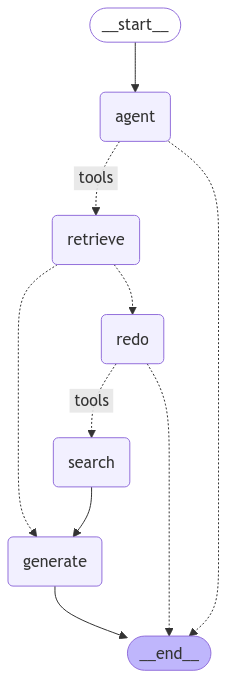

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
import pprint

inputs = {
    "messages": [
        ("user", "What is the age of Mrs. Oscar W?"),
    ]
}

In [24]:
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content=[{'type': 'tool_use', 'name': 'retrieve_csv_file', 'input': {'query': 'Mrs. Oscar W'}, 'id': 'tooluse_RsSG2qLfTdWfzXV7VkXmPA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '4f2283f6-b0d2-481c-91b2-54f553cca9c7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 31 Jan 2025 07:52:18 GMT', 'content-type': 'application/json', 'content-length': '289', 'connection': 'keep-alive', 'x-amzn-requestid': '4f2283f6-b0d2-481c-91b2-54f553cca9c7'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [676]}}, id='run-24825f22-187b-4c9e-bea6-e1d2aa8a3e40-0', tool_calls=[{'name': 'retrieve_csv_file', 'args': {'query': 'Mrs. Oscar W'}, 'id': 'tooluse_RsSG2qLfTdWfzXV7VkXmPA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 93, 'output_tokens': 29, 'total_tokens': 122})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve'

In [25]:
inputs = {
    "messages": [
        ("user", "Who is the captain of Titanic?"),
    ]
}

In [26]:
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content=[{'type': 'tool_use', 'name': 'retrieve_csv_file', 'input': {'query': 'captain of Titanic'}, 'id': 'tooluse_3sVVtFsqQsOTuxXhjMkEZw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '2f23543f-9465-4c79-a66e-4a192bb7786a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 31 Jan 2025 07:52:33 GMT', 'content-type': 'application/json', 'content-length': '295', 'connection': 'keep-alive', 'x-amzn-requestid': '2f23543f-9465-4c79-a66e-4a192bb7786a'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [691]}}, id='run-1d7f36f0-9684-4794-b148-dce6b7758fe6-0', tool_calls=[{'name': 'retrieve_csv_file', 'args': {'query': 'captain of Titanic'}, 'id': 'tooluse_3sVVtFsqQsOTuxXhjMkEZw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 92, 'output_tokens': 31, 'total_tokens': 123})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output f